# Deterministic slice flows

Consider a target density $\pi(x,u)=p(x)1_{[0,1]}(u)$ and let $F$ be the cdf of $p$.
Here the idea is to update a pair $(x,u)$ via
$$
\begin{pmatrix}x\\u\end{pmatrix}=
\begin{pmatrix}
    F^{-1}(\rho(u,x)+\xi\mod 1)\\ 
    \frac{1}{p(x')}((\rho(u,x)+\xi\mod 1)-F(x'))
\end{pmatrix},
$$
where $\rho(u,x)=F(x-1)+up(x)$ converts to proportions and $F(0)=0$ by convention.

We consider a univariate and a bivariate examples, 
both taken from Trevor's ipynb.
First we define all the necessary functions.

In [57]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [470]:
# main functions
def update(x,u,prbs,xi=np.pi/16,direction='fwd'):
    if direction=='bwd': xi=-xi
    p=getp(x,u,prbs,xi)
    xp=quantile(p,prbs)
    up=(p-cdf(xp-1,prbs))/prbs[xp]
    return xp,up


def getp(x,u,prbs,xi=np.pi/16):
    p=u*prbs[x]
    if x>0:  p+=np.sum(prbs[:x])
    #return lcg_update(p*2e32,m=2e32,a=1664525.,c=1013904223.)/2e32
    return (p+xi)%1

def int_update(x,u,prbs,xi=np.pi/16,bigint=1e1,direction='fwd'):
    if direction=='bwd': xi=-xi 
    # integerize
    Mu=int(u*bigint)
    Mprbs=(prbs*bigint).astype(int)
        
    Mp=int_getp(x,Mu,Mprbs,xi,modulus=bigint)
    xp=quantile(Mp,Mprbs)
    Mup=M*(Mp-cdf(xp-1,Mprbs))/Mprbs[xp]
    return xp,Mup/M
    #return xp,up

def int_getp(x,u,prbs,xi=np.pi/16,modulus=1):
    p=int(u*prbs[x]/modulus)
    if x>0:  p+=np.sum(prbs[:x])
    #return lcg_update(p*2e32,m=2e32,a=1664525.,c=1013904223.)/2e32
    return (p+int(modulus*xi))%modulus
    
# auxiliary functions
def cdf(x,prbs): return np.sum(prbs[:(x+1)])
def quantile(u,prbs): return np.argmax(np.cumsum(prbs)>u)
def lcg_update(u,m,a=1.,c=0.): return (a*u+c)%m

In [471]:
# demo
n_iters=10
M=1e8
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
u=np.zeros(n_iters+1)
u[0]=np.random.rand()
u[0]=0.10688645379435302 # trevor's example
u[0]=0.555

# forward map
print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')')
for it in range(n_iters):
    print(x[it],u[it])
    tmpx,tmpu=int_update(x[it],u[it],prbs,xi,bigint=M)
    x[it+1]=tmpx
    u[it+1]=tmpu
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')')

Initial (u,x)=(0.555,1)
0 0.555
1 0.4356027273568679
1 0.9237323001021333
2 0.7163523013341105
3 0.4098749662931436
0 0.1705831434312119
1 0.3902269538212906
1 0.8783565265665559
2 0.6374301142127261
3 0.3526576363325962
Final (u,x)=(0.9681726711422727,4)


In [472]:
# backward map
tu=u[-1]
tx=x[-1]
print('Final (u,x)=('+str(tu)+','+str(tx+1)+')')
for it in range(n_iters):
    print(tx,tu)
    tx,tu=int_update(tx,tu,prbs,xi,bigint=M,direction='bwd')
# end for
print('Initial (u,x)=('+str(tu)+','+str(tx+1)+')')

Final (u,x)=(0.9681726711422727,4)
3 0.9681726711422727
3 0.3526575736367461
2 0.6374299412548612
1 0.8783563774051377
1 0.39022675493939957
0 0.1705810373078689
3 0.4098745901180431
2 0.7163516959815834
1 0.9237319023383513
1 0.4356022798726132
Initial (u,x)=(0.554995935181948,1)


- accuracy increases when $M$ increases
- might be able to show that asymptotically we're fine
- but in practice not the case
- also this should work for any $M$ anyway
- problem seems to be division in last step
- returning int$(Mu)/M$ instead of $M$ doesn't help

## Univariate example

We generate a random probability distribution.
(For now we actually use the same one as in Trevor's ipynb to replicate results.)
Then we run our algorithm for 1,000 iterations and produce some diagnostic plots.

In [154]:
# generate the distribution
np.random.seed(2022)
K=4
prbs=np.random.rand(K)
prbs=np.array([0.047480609696438775, 0.40224879672133207, 0.23127020434512163, 0.31900038923710755]) # trevor's example
prbs=prbs/np.sum(prbs)
prbs

array([0.04748061, 0.4022488 , 0.2312702 , 0.31900039])

In [349]:
# demo
n_iters=1000
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
u=np.zeros(n_iters+1)
u[0]=np.random.rand()
u[0]=0.10688645379435302 # trevor's example

# forward map
print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')')
for it in range(n_iters):
    tmpx,tmpu=update(x[it],u[it],prbs,xi)
    x[it+1]=tmpx
    u[it+1]=tmpu
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')')

Initial (u,x)=(0.10688645379435302,1)
Final (u,x)=(0.7635455373974748,2)


### Inversion diagnostic

Since this map is easily invertible,
we push the final particle back for 1,000 iterations to ensure that it reaches the original point.

In [350]:
# backward map
tu=u[-1]
tx=x[-1]
print('Final (u,x)=('+str(tu)+','+str(tx+1)+')')
for it in range(n_iters):
    tx,tu=update(tx,tu,prbs,xi,'bwd')
# end for
print('Initial (u,x)=('+str(tu)+','+str(tx+1)+')')

Final (u,x)=(0.7635455373974748,2)
Initial (u,x)=(0.10688645379435248,1)


We got the same $x$ labels, but the uniform variate is ever so slightly different.
In particular, the difference is of the order of $10^{15}$.
However, as we'll see later on, these differences add up to big deviations.

### Uniformity test

Here we study the trace of the uniform variate.
Notice that there is a clear pattern,
which is expected from the simple lcg update.

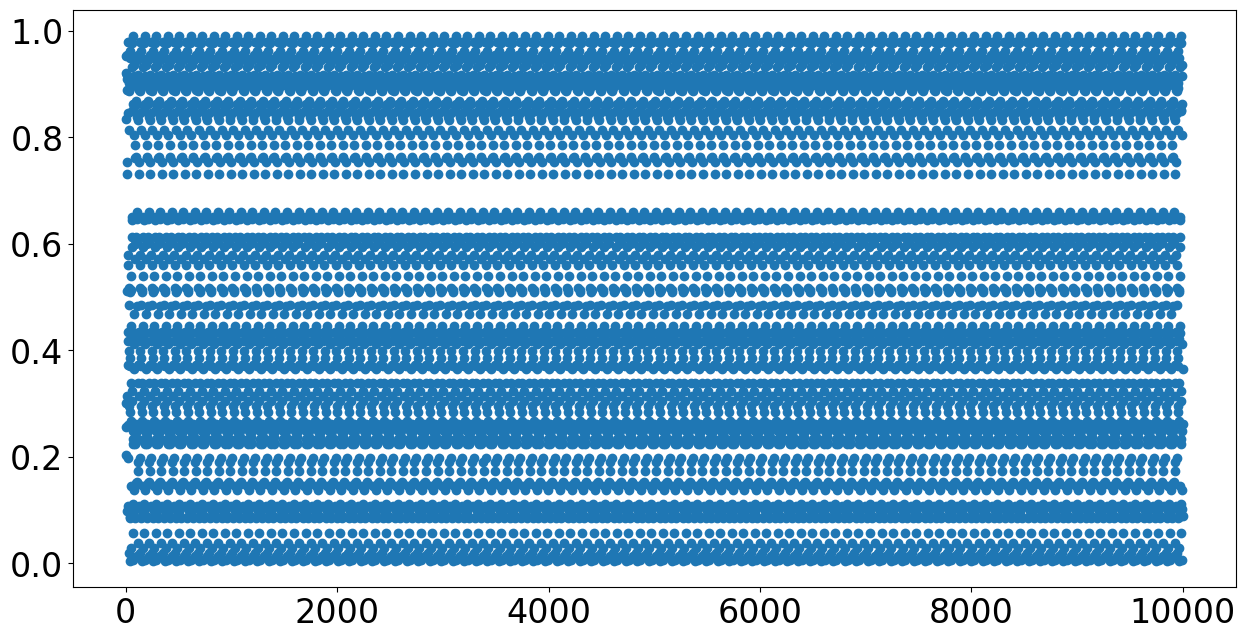

In [217]:
plt.clf()
plt.scatter(np.arange(1,n_iters+1),u[1:])

### Quality of empirical approximation

Now we estimate the marginal empirical probability distribution of $X$ after all iterations.
The final approximation is good,
and we note that it doesn't take too long for the probabilities to stabilize around their true values.

In [218]:
eprbs=plt.hist(x,bins=np.arange(prbs.shape[0]+1),density=True)[0]
plt.clf()
print('True: '+str(prbs))
print('Empirical: '+str(eprbs))

True: [0.04748061 0.4022488  0.2312702  0.31900039]
Empirical: [0.04579542 0.26587341 0.38546145 0.30286971]


<Figure size 1500x750 with 0 Axes>

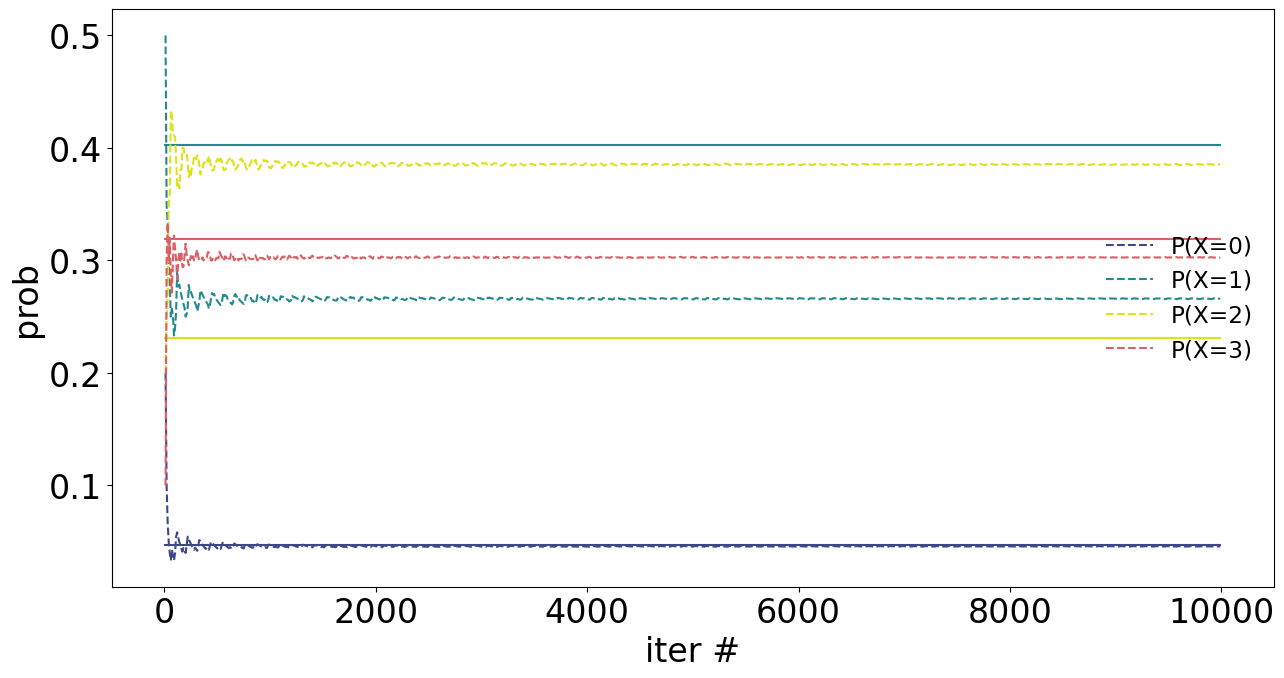

In [219]:
freqs=np.zeros((int(n_iters/10)-1,prbs.shape[0]))

i=0
for it in 10*np.arange(1,n_iters/10):
    freqs[i,:]=plt.hist(x[:int(it)],bins=np.arange(prbs.shape[0]+1),density=True)[0]
    i=i+1
plt.clf()

colors=['#3F4788','#238A8D','#DCE318','#DD5E66']

for n in range(prbs.shape[0]):
    plt.plot(10*np.arange(1,n_iters/10),freqs[:,n],c=colors[n], label='P(X='+str(n)+')',ls='dashed')
    plt.hlines(prbs[n],0,n_iters,colors=colors[n])
# end for
plt.xlabel('iter #')
plt.ylabel('prob')
plt.legend(fontsize='x-small',loc='center right',frameon=False)

## Bivariate example

Now we consider a random 4x4 bivariate density.
(As before, we take Trevor's example to compare.)
We now run 10,000 iterations of the chain.

In [17]:
np.random.seed(2022)
prbs=np.array([[0.0903257, 0.031233, 0.0648814, 0.0201844],
 [0.022866, 0.0872383, 0.00311221, 0.0900461],
 [0.0612982, 0.0145122, 0.03126, 0.120812],
 [0.13305, 0.0718069, 0.0893575, 0.0680155]]) # trevor's example
#prbs=np.random.rand(4,4)
prbs=prbs/np.sum(prbs)
print(prbs)

[[0.09032575 0.03123302 0.06488144 0.02018441]
 [0.02286601 0.08723835 0.00311221 0.09004615]
 [0.06129824 0.01451221 0.03126002 0.12081207]
 [0.13305008 0.07180694 0.08935755 0.06801554]]


In [47]:
# demo
n_iters=100000
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
y=np.zeros(n_iters+1,dtype=int)+2
u=np.zeros(n_iters+1)
v=np.zeros(n_iters+1)
u[0]=np.random.rand()
v[0]=np.random.rand()
u[0]=0.2654657001673143 # trevor's example
v[0]=0.40302657652555507 # trevor's example

print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')   (v,y)=('+str(v[0])+','+str(y[0]+1)+')')

# forward map
for it in range(n_iters):
    # step in (x,u)
    xprbs=prbs[:,y[it]]/np.sum(prbs[:,y[it]])
    tmpx,tmpu=update(x[it],u[it],xprbs)
    x[it+1]=tmpx
    u[it+1]=tmpu
    # step in (y,v)
    yprbs=prbs[x[it+1],:]/np.sum(prbs[x[it+1],:])
    tmpy,tmpv=update(y[it],v[it],yprbs)
    y[it+1]=tmpy
    v[it+1]=tmpv
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')   (v,y)=('+str(v[-1])+','+str(y[-1]+1)+')')

Initial (u,x)=(0.2654657001673143,1)   (v,y)=(0.40302657652555507,3)
Final (u,x)=(0.8705186977429785,4)   (v,y)=(0.6413630977787956,4)


### Inversion diagnostic

As before, we push the final particle through the inverse map for 10,000 iterations.
Unlike before, however,
we no longer recover the original values!
This is probably due to numerical errors&mdash;i.e., instability in the numerical inversion.

In [48]:
# backward map
tu=u[-1]
tx=x[-1]
tv=v[-1]
ty=y[-1]
print('Final (u,x)=('+str(tu)+','+str(tx+1)+')   (v,y)=('+str(tv)+','+str(ty+1)+')')
for it in range(n_iters):
    ty,tv=update(ty,tv,prbs[tx,:]/np.sum(prbs[tx,:]),xi,'bwd')
    tx,tu=update(tx,tu,prbs[:,ty]/np.sum(prbs[:,ty]),xi,'bwd')
# end for
print('Initial (u,x)=('+str(tu)+','+str(tx+1)+')   (v,y)=('+str(tv)+','+str(ty+1)+')')

Final (u,x)=(0.8705186977429785,4)   (v,y)=(0.6413630977787956,4)
Initial (u,x)=(0.6881814835595836,1)   (v,y)=(0.28628708514618634,1)


### Uniformity test

Here we study the trace of the uniform variate.
Interestingly, there no longer appear to be any patterns in the uniform traceplot...
Still thinking why this is the case.
(This was also true in Trevor's example, btw.)

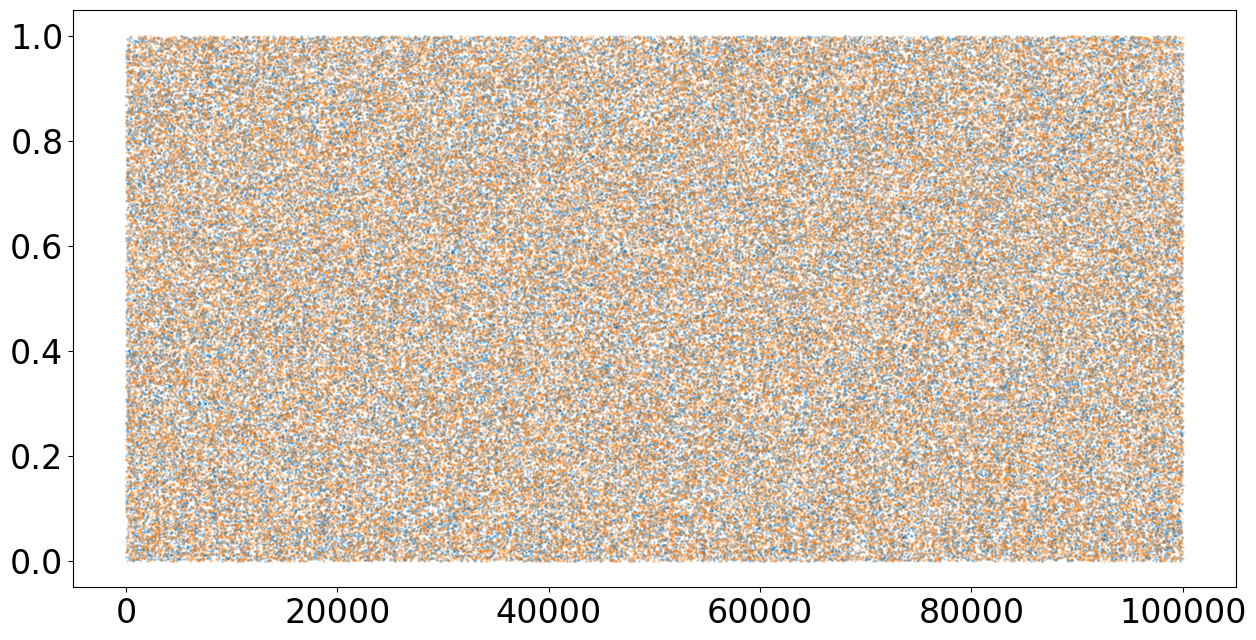

In [50]:
plt.clf()
plt.scatter(np.arange(1,n_iters+1),u[1:], label='u', alpha=0.25,s=1)
plt.scatter(np.arange(1,n_iters+1),v[1:], label='v', alpha=0.25,s=1)
#plt.legend(fontsize='x-small',frameon=False)

### Quality of empirical approximation

Now we estimate the marginal empirical probability distribution of $(X,Y)$ after all iterations.
The final approximation is also good,
and we note that it again doesn't take too long for the probabilities to stabilize around their true values.

In [51]:
eprbs=plt.hist2d(x,y,bins=[np.arange(prbs.shape[0]+1),np.arange(prbs.shape[1]+1)], density=True)[0]
plt.clf()
print('True: '+str(prbs))
print('Empirical: '+str(eprbs))

True: [[0.09032575 0.03123302 0.06488144 0.02018441]
 [0.02286601 0.08723835 0.00311221 0.09004615]
 [0.06129824 0.01451221 0.03126002 0.12081207]
 [0.13305008 0.07180694 0.08935755 0.06801554]]
Empirical: [[0.08793912 0.03240968 0.06582934 0.0202798 ]
 [0.02224978 0.08552914 0.00329997 0.09168908]
 [0.06279937 0.01397986 0.0298597  0.12215878]
 [0.13525865 0.07347927 0.08733913 0.06589934]]


<Figure size 1500x750 with 0 Axes>

In [52]:
binsize=100
xfreqs=np.zeros((int(n_iters/binsize)-1,prbs.shape[0]))
yfreqs=np.zeros((int(n_iters/binsize)-1,prbs.shape[0]))

i=0
for it in binsize*np.arange(1,n_iters/binsize):
    xfreqs[i,:]=plt.hist(x[:int(it)],bins=np.arange(prbs.shape[0]+1),density=True)[0]
    yfreqs[i,:]=plt.hist(y[:int(it)],bins=np.arange(prbs.shape[0]+1),density=True)[0]
    i=i+1
plt.clf()

<Figure size 1500x750 with 0 Axes>

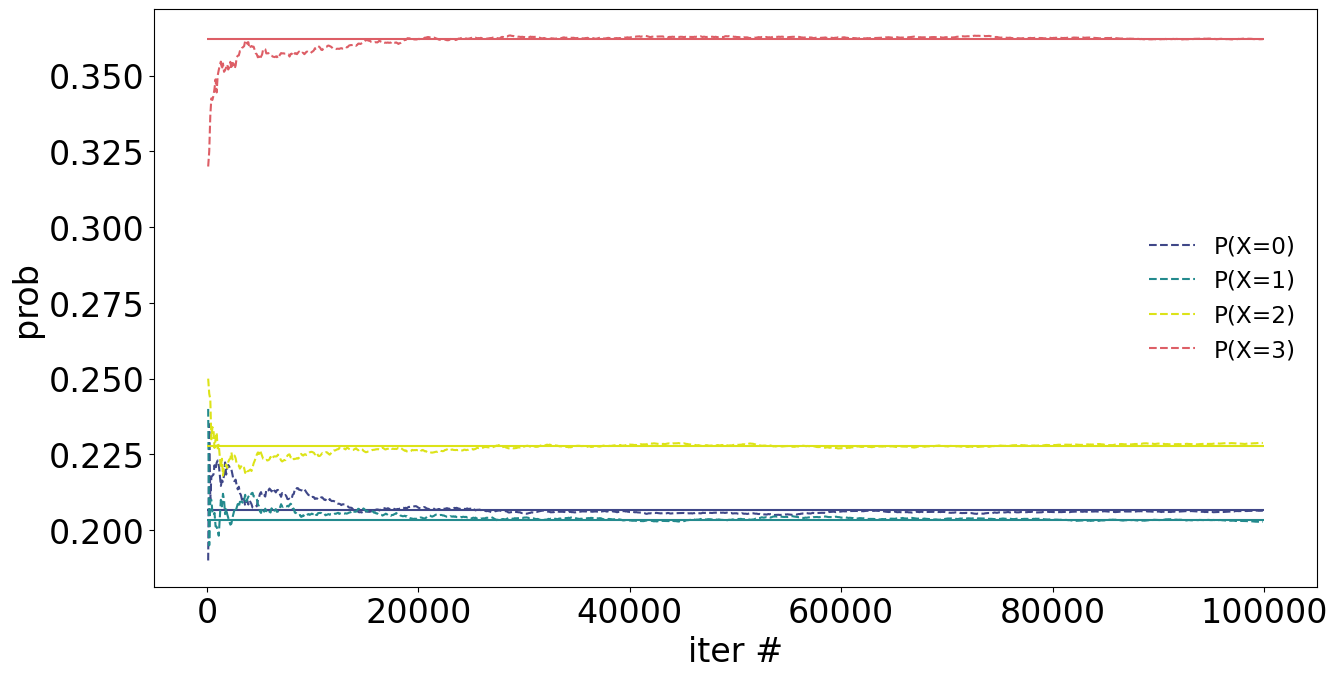

In [53]:
for n in range(prbs.shape[0]):
    plt.plot(binsize*np.arange(1,n_iters/binsize),xfreqs[:,n],c=colors[n], label='P(X='+str(n)+')',ls='dashed')
    plt.hlines(np.sum(prbs[n,:]),0,n_iters,colors=colors[n])
# end for
plt.xlabel('iter #')
plt.ylabel('prob')
plt.legend(fontsize='x-small',loc='center right',frameon=False)

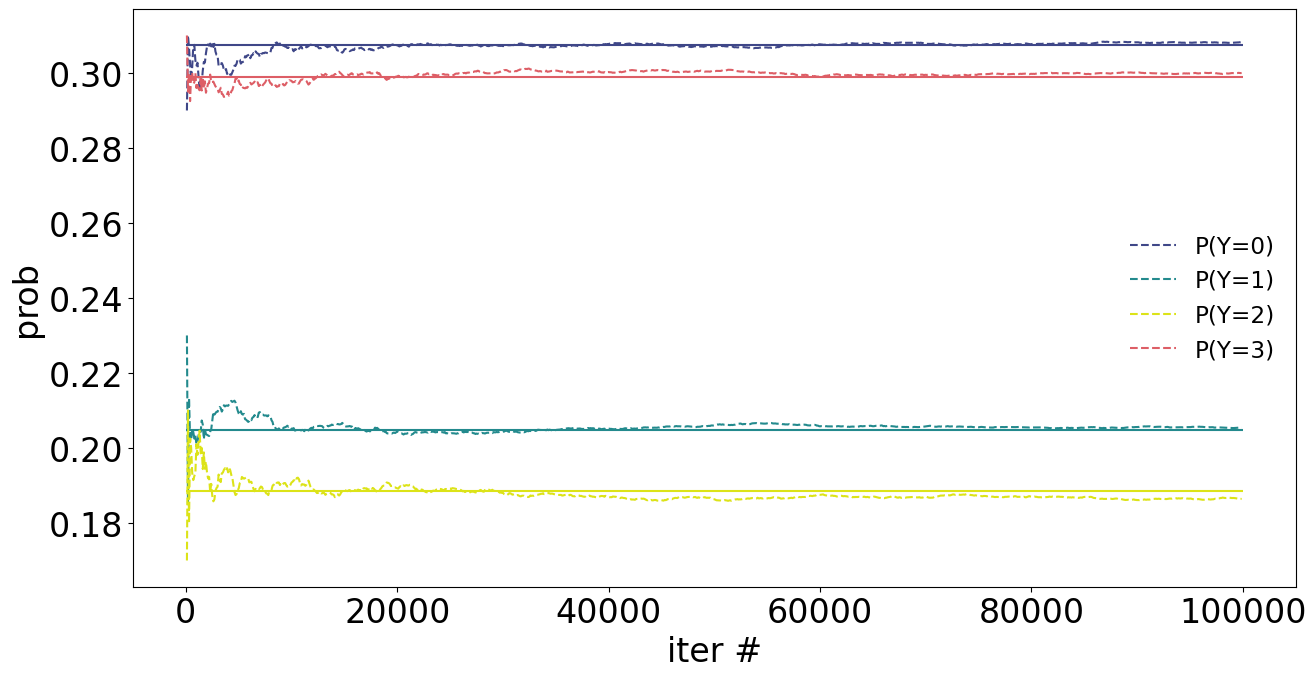

In [54]:
for n in range(prbs.shape[0]):
    plt.plot(binsize*np.arange(1,n_iters/binsize),yfreqs[:,n],c=colors[n], label='P(Y='+str(n)+')',ls='dashed')
    plt.hlines(np.sum(prbs[:,n]),0,n_iters,colors=colors[n])
# end for
plt.xlabel('iter #')
plt.ylabel('prob')
plt.legend(fontsize='x-small',loc='center right',frameon=False)